In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import re

In [21]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [19]:
path = 'data/Images/HG/0001/'
subpaths = ['VSD.Brain.XX.O.MR_Flair', 'VSD.Brain.XX.O.MR_T1', 'VSD.Brain.XX.O.MR_T1c', 'VSD.Brain.XX.O.MR_T2']
fp1 = os.path.join(path, 'VSD.Brain_?more.XX.XX.OT')
label_path = os.path.basename(glob.glob(fp1)[0])
# 'VSD.Brain_3more.XX.XX.OT'

images = list(load_images(path, subpaths))
images_norm = normalize_images(images)
label_image = list(load_images(path, [label_path]))[0]

In [20]:
images[0].shape

(176, 216, 160)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
import numpy
import scipy.ndimage
import glob
import os
import re

In [7]:
def identity(x):
    return x

def leaky_relu(x):
    alpha = 0.1
    out = tf.maximum(alpha*x,x)
    return out

def batch_norm(_X, name):
    with tf.variable_scope(name):
        _, _, _, c = _X.get_shape().as_list()
        mean, var = tf.nn.moments(_X, [0, 1, 2])
        offset = tf.get_variable('offset',
                                 shape=[c],
                                 initializer=tf.constant_initializer(value=0.0))
        scale = tf.get_variable('scale',
                                 shape=[c],
                                 initializer=tf.constant_initializer(value=1.0))
        output = tf.nn.batch_normalization(_X, mean, var, offset, scale, 1e-5)
    return output

def conv(_X, out_dim, name, size=3, gain=numpy.sqrt(2), func=leaky_relu):
    with tf.variable_scope(name):
        in_dim = _X.get_shape().as_list()[-1]
        stddev = gain / numpy.sqrt(size*size*in_dim)
        w_init = tf.random_normal_initializer(stddev=stddev)
        w = tf.get_variable('w', shape=[size, size, in_dim, out_dim], initializer=w_init)
        b_init = tf.constant_initializer(value=0.0)
        b = tf.get_variable('b', shape=[out_dim], initializer=b_init)
        output = func(tf.nn.conv2d(_X, w, strides=[1, 1, 1,1], padding='SAME') + b)
    return output

def generate_samples():
    n_samples = 4123
    n_epochs = 1000
    n_batches = n_samples/batch_size
    for _ in range(n_epochs):
        sample_ids = numpy.random.permutation(n_samples)
        for i in range(n_batches):
            inds = slice(i*batch_size, (i+1)*batch_size)
            yield sample_ids[inds]
            
images = numpy.load('images.npy')
labels = numpy.load('labels.npy')

In [8]:
def zoom(image, zoom_factor, order):
    image = scipy.ndimage.interpolation.zoom(image, zoom_factor, mode='nearest', order=order)
    w, h = image.shape
    if zoom_factor > 1.0:
        image = image[(w-width)/2:width+(w-width)/2, (h-height)/2:height+(h-height)/2]
    else:
        width_diff = width - w
        top_diff = width_diff / 2
        bot_diff = width_diff - top_diff
        height_diff = height - h
        left_diff = height_diff / 2
        right_diff = height_diff - left_diff
        image = numpy.pad(image, ((top_diff, bot_diff), (left_diff, right_diff)), 'edge')   
    return image


def augment_sample(image, label):
    # Flipping
    if numpy.random.binomial(1, 0.5):
        image = image[:, ::-1, :]
        label = label[:, ::-1, :]
    
    # Rotating
    r = numpy.random.uniform(-15.0, 15.0)
    for i in range(n_channels):
        image[:,:,i] = scipy.ndimage.interpolation.rotate(image[:,:,i], r, reshape=False, mode='nearest')
    for i in range(n_classes):
        label[:,:,i] = scipy.ndimage.interpolation.rotate(label[:,:,i], 15, reshape=False, mode='nearest', order=0)
        
    # Zooming
    z = numpy.random.uniform(0.9, 1.2)
    for i in range(n_channels):
        image[:,:,i] = zoom(image[:,:,i], z, 3)
    for i in range(n_classes):
        label[:,:,i] = zoom(label[:,:,i], z, 0)
    
    # Shifting
    sv = numpy.random.randint(-20, 20)
    sh = numpy.random.randint(-20, 20)
    for i in range(n_channels):
        image[:,:,i] = scipy.ndimage.interpolation.shift(image[:,:,i], [sv, sh], mode='nearest')
    for i in range(n_classes):
        label[:,:,i] = scipy.ndimage.interpolation.shift(label[:,:,i], [sv, sh], mode='nearest', order=0)
    
    return(image, label)


def generate_batch():
    for samples in generate_samples():
        image_batch = images[samples, :, :, :]
        label_batch = labels[samples, :, :, :]
        for i in range(image_batch.shape[0]):
            image_batch[i], label_batch[i] = augment_sample(image_batch[i], label_batch[i])
        yield(image_batch, label_batch)

In [18]:
# Parameters
training_iters = 200000
batch_size = 1
display_step = 20

# Network Parameters
width = 216
height = 160
n_channels = 4
n_classes = 5 # total classes (normal, non-normal)

In [9]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, width, height, n_channels])
y = tf.placeholder(tf.float32, [None, width, height, n_classes])
lr = tf.placeholder(tf.float32)
weights = tf.placeholder(tf.float32, [batch_size*width*height])

def layer(_X, name):
    with tf.variable_scope(name):
        c = conv(_X, 64, 'conv')
        bn = batch_norm(c, 'bn')
    return bn
    
def tom_net(_X):
    # Convolution Layer
    nb_layers = 25
    _input = batch_norm(_X, 'input_bn')
    for i in range(nb_layers):
        _input = layer(_input, str(i))

    out = conv(_input, n_classes, 'output', gain=1.0, func=identity)
    return out

# Construct model
pred = tom_net(x)

# Define loss and optimizer
pred_reshape = tf.reshape(pred, [batch_size*width*height, n_classes])
y_reshape = tf.reshape(y, [batch_size*width*height, n_classes])

error = tf.nn.softmax_cross_entropy_with_logits(pred_reshape, y_reshape)
cost = tf.reduce_mean(error * weights)
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,3), tf.argmax(y,3))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

In [10]:
arg_labels = numpy.argmax(labels, axis=3)
class_weights = numpy.zeros(n_classes)
for i in range(n_classes):
    class_weights[i] = 1/numpy.mean(arg_labels == i)**0.3
class_weights /= numpy.sum(class_weights)

In [11]:
class_weights

array([ 0.04610796,  0.29065991,  0.16969985,  0.25641113,  0.23712116])

In [12]:
# Launch the graph
sess = tf.Session()
sess.run(init)

In [18]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()
model_path = "./models-e2e/model.ckpt"
learning_rate = 0.001

saver.restore(sess, model_path)

In [ ]:
# For each iteration over all data
for step, (image_batch, label_batch) in enumerate(generate_batch()):            
    label_vect = numpy.reshape(numpy.argmax(label_batch, axis=3), [batch_size*width*height])
    weight_vect = class_weights[label_vect]
    # Fit training using batch data
    feed_dict = {x: image_batch, y: label_batch, weights: weight_vect, lr:learning_rate}
    loss, acc, _ = sess.run([cost, accuracy, optimizer], feed_dict=feed_dict)
    if step % display_step == 0:
        print("Step %d, Minibatch Loss=%0.6f , Training Accuracy=%0.5f " 
              % (step, loss, acc))

        # Save the variables to disk.
        saver.save(sess, model_path)
    if step % 2000 == 0:
        learning_rate *= 0.9

In [ ]:
saver = tf.train.Saver()
model_path = "./models-e2e/model.ckpt"

# Restore the graph
saver.restore(sess, model_path)

In [ ]:
samples = next(generate_samples())
image_batch = images[samples, :, :, :]
label_batch = labels[samples, :, :, :]
label_vect = numpy.reshape(numpy.argmax(label_batch, axis=3), [batch_size*width*height])
weight_vect = class_weights[label_vect]
# Fit training using batch data
feed_dict = {x: image_batch, y: label_batch, weights: weight_vect}
# Fit training using batch data
loss, out = sess.run([cost, tf.nn.softmax(pred_reshape)], feed_dict=feed_dict)
_out = numpy.reshape(out, (batch_size, width, height, n_classes))

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(numpy.argmax(_out[0], axis=2))
plt.colorbar()
plt.clim([0,5])
plt.subplot(1, 3, 2)
plt.imshow(numpy.argmax(image_batch[0], axis=2))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(numpy.argmax(label_batch[0], axis=2))
plt.colorbar()
plt.clim([0,5])
fig = plt.gcf()
fig.set_size_inches(6*3, 6)
loss

In [7]:
import SimpleITK as sitk
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
from collections import Counter

def find_files_in_dir(path, endswith):
    for _file in os.listdir(path):
        if _file.endswith(endswith):
            yield _file

def adjust_3d_size(image, new_width, new_height):
    _, w, h = image.shape
    if w == new_width:
        pass
    elif w < new_width:
        width_diff = new_width - w
        top_diff = width_diff / 2
        bot_diff = width_diff - top_diff
        image = numpy.pad(image, ((0, 0), (top_diff, bot_diff), (0, 0)), 'edge')
    else:
        image = image[:, (w-new_width)/2:new_width+(w-new_width)/2, :]
    
    if h == new_height:
        pass
    if h < new_height:
        height_diff = new_height - h
        left_diff = height_diff / 2
        right_diff = height_diff - left_diff
        image = numpy.pad(image, ((0, 0), (0, 0), (left_diff, right_diff)), 'edge')
    else:
        image = image[:, :, (h-new_height)/2:new_height+(h-new_height)/2]
    return image 


def get_image_size(path, subpath):
    fullpath = os.path.join(path, subpath)
    image_files = list(find_files_in_dir(fullpath, 'mha'))
    assert len(image_files) == 1
    image = sitk.ReadImage(os.path.join(fullpath, image_files[0]))
    arr = sitk.GetArrayFromImage(image)
    return arr.shape


def load_images(path, subpaths):
    for sp in subpaths:
        fullpath = os.path.join(path, sp)
        image_files = list(find_files_in_dir(fullpath, 'mha'))
        assert len(image_files) == 1
        image = sitk.ReadImage(os.path.join(fullpath, image_files[0]))
        arr = sitk.GetArrayFromImage(image)
        arr = adjust_3d_size(arr, width, height)
        yield arr
        
def merge_images_into_channels(images):
    image = np.zeros((len(images), images.shape[0], images.shape[1]))
    for i, img in images:
        image[i, :, :] = img
    return image

def normalize_images(images):
    out = []
    for image in images:
        mean = np.mean(image)
        std = np.std(image)
        image = (image - mean) / std
        out.append(image)
#         print('===>', np.min(image), np.max(image))
#         print('===>', mean, std)
#         print('===>', np.min(out), np.max(out))
        # out.append(np.uint8(image * 255.0 / np.max(image)))
    return out

def show_images(images, label_image, Z):
    f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5)
    ax = [ax1, ax2, ax3, ax4]
    for i in range(channels):
        cax = ax[i].imshow(images[i][Z,:,:])
        ax[i].axis('off')
        f.colorbar(cax, ax = ax[i])

    ax5.imshow(label_image[Z,:,:])
    ax5.axis('off')
    
    fig = plt.gcf()
    fig.set_size_inches(23, 4)    
    

def get_patch(images, x, y, z, size):
    patch = np.zeros((size, size, len(images)))
    for idx, image in enumerate(images):
        patch[:, :, idx] = image[z, x-size/2:x+size/2, y-size/2:y+size/2]
    return patch


def get_label(label_image, x, y, z):
    out = np.zeros(label_count)
    out[label_image[z,x,y]] = 1
    return out > 0


def decompose_label(label_image):
    w, h = label_image.shape
    output = np.zeros((w,h,n_classes), dtype=np.float32)
    for x in range(w):
        for y in range(h):
            output[x,y,label_image[x,y]] = 1.0
    return output


def load_all_files(image_id):
    path = image_id
    subpaths = ['VSD.Brain.XX.O.MR_Flair', 'VSD.Brain.XX.O.MR_T1', 'VSD.Brain.XX.O.MR_T1c', 'VSD.Brain.XX.O.MR_T2']
    fp1 = os.path.join(path, 'VSD.Brain_?more.XX.XX.OT')
    label_path = os.path.basename(glob.glob(fp1)[0])
    # 'VSD.Brain_3more.XX.XX.OT'

    images = list(load_images(path, subpaths))
    images_norm = normalize_images(images)
    label_image = list(load_images(path, [label_path]))[0]
    return (images_norm, label_image)


def generate_2d_images(images_norm, label_image):
    d, w, h = images_norm[0].shape
    image = np.zeros((w, h, n_channels), dtype=np.float32)
    for z in range(d):
        for i in range(n_channels):
            image[:,:,i] = images_norm[i][z,:,:]
            label = None
            if label_image != None:
                label = decompose_label(label_image[z,:,:])
        yield (image, label)

def generate_all_2d_images():
    image_ids = glob.glob('data/Images/*/*')
    for image_id in image_ids:
        print(image_id)
        (images_norm, label_image) = load_all_files(image_id)
        for (image, label) in generate_2d_images(images_norm, label_image):
            if (np.max(image) - np.min(image) < 0.1):
                continue
            yield(image, label)



In [34]:
def image_generation():
    nb_images = 4123
    w = width
    h = height
    
    images = np.zeros((nb_images, w, h, n_channels), dtype=np.float32)
    labels = np.zeros((nb_images, w, h, n_classes), dtype=np.float32)
    
    count = 0
    for (image, label) in generate_all_2d_images():
        images[count] = image
        labels[count] = label
        count += 1
    
    print(count)
    np.save('images', images[:count])
    np.save('labels', labels[:count])

In [35]:
image_generation()

data/Images/HG/0004
data/Images/HG/0001


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:134: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


KeyboardInterrupt: 

In [103]:
image_ids = sorted(glob.glob('data/Images/*/*'))
nb_images = 0
for image_id in image_ids:
    (images_norm, label_image) = load_all_files(image_id)
    nb_images += images_norm[0].shape[0]
    print(image_id, images_norm[0].shape)
print(nb_images)

('data/Images/HG/0001', (176, 216, 160))
('data/Images/HG/0002', (176, 216, 160))
('data/Images/HG/0003', (176, 216, 176))
('data/Images/HG/0004', (176, 216, 160))
('data/Images/HG/0005', (176, 216, 160))
('data/Images/HG/0006', (176, 236, 216))
('data/Images/HG/0007', (176, 216, 176))
('data/Images/HG/0008', (176, 216, 160))
('data/Images/HG/0009', (176, 216, 160))
('data/Images/HG/0010', (176, 216, 160))
('data/Images/HG/0011', (176, 216, 176))
('data/Images/HG/0012', (176, 216, 176))
('data/Images/HG/0013', (176, 216, 176))
('data/Images/HG/0014', (176, 216, 176))
('data/Images/HG/0015', (176, 216, 160))
('data/Images/HG/0022', (165, 230, 230))
('data/Images/HG/0024', (240, 240, 168))
('data/Images/HG/0025', (230, 230, 162))
('data/Images/HG/0026', (220, 220, 168))
('data/Images/HG/0027', (230, 230, 162))
('data/Images/LG/0001', (176, 196, 216))
('data/Images/LG/0002', (176, 236, 216))
('data/Images/LG/0004', (176, 236, 216))
('data/Images/LG/0006', (196, 216, 159))
('data/Images/LG

### Testing

In [15]:
def get_challenge_image_id(path):
    return re.split('\.', glob.glob(os.path.join(path, '*Flair*/*.mha'))[0])[-2]

In [24]:
def write_outputs(image_ids):
    #image_ids = glob.glob('%s/*' % base_path)
    for image_id in image_ids:
        print(image_id)
        image_challenge_id = get_challenge_image_id(image_id)

        subpaths = [re.split('/', xxx)[-1] for xxx in glob.glob(image_id + "/*")]
        images_norm = list(load_images(image_id, subpaths))
        d, w, h = images_norm[0].shape
        output_image = np.zeros((d,w,h), dtype=np.uint16)
        image_batch = np.zeros((1,w,h,n_channels), dtype=np.float32)
        for idx, (image, _) in enumerate(generate_2d_images(images_norm, None)):
            if (np.max(image) - np.min(image) < 0.1):
                continue
            image_batch[0] = image
            out = sess.run(tf.nn.softmax(pred_reshape), feed_dict={x: image_batch})
            _out = np.reshape(out, (batch_size, width, height, n_classes))            
            output_image[idx, :, :] = numpy.argmax(_out, axis=3)
    
        # resize to original
        _, org_width, org_height = get_image_size(image_id, subpaths[0])
        output = adjust_3d_size(output_image, org_width, org_height)
        yield (images_norm, output_image, output)
        # return output
        sitk.WriteImage(sitk.GetImageFromArray(output), 'output/VSD.MBZ_test_0001.%s.mha' % image_challenge_id)

In [25]:
# output = write_outputs('data/Challenge/HG')
# write_outputs('data/2015')
(images_norm, output_image, output) = next(write_outputs(image_ids=sorted(glob.glob('data/Images/*/*'))))

data/Images/HG/0001


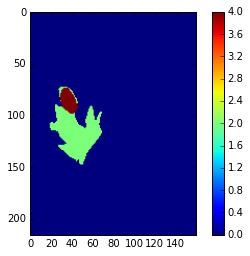

In [31]:
plt.imshow(images_norm[4][100,:,:])
plt.colorbar()

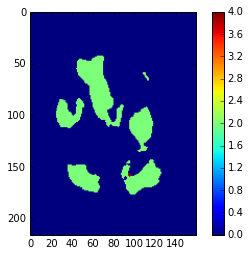

In [33]:
plt.imshow(output_image[100,:,:])
plt.colorbar()

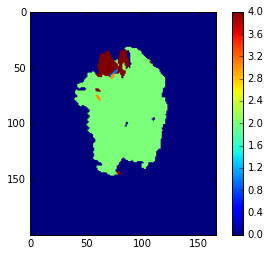

In [17]:
plt.imshow(output[120,:,:])
plt.colorbar()

In [45]:
image = sitk.ReadImage('data/Challenge/HG/0301/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.17572.mha')
arr = sitk.GetArrayFromImage(image)
_, width, height = arr.shape

In [46]:
arr.shape

(140, 180, 158)

In [47]:
image = sitk.ReadImage('output/VSD.MBZ_test_0001.17572.mha')
arr = sitk.GetArrayFromImage(image)
# arr_resized = adjust_3d_size(arr)

In [48]:
arr_resized.shape

(140, 180, 158)

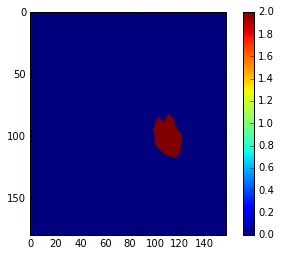

In [16]:
plt.imshow(arr_resized[50,:,:])
plt.colorbar()